# 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Filtering out the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the dataset
df01 = pd.read_csv("Country-data.csv")
df01.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# basics of the df
df01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


# 2. Clean the data

In [4]:
# missing values
round(100*(df01.isnull().sum())/len(df01), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

# 3. Prepare the data for modelling

In [5]:
# analyzing selected columns
df02 = df01[["country","child_mort","income","gdpp"]]
df02

,country,child_mort,income,gdpp
0,Afghanistan,90.2,1610,553
1,Albania,16.6,9930,4090
2,Algeria,27.3,12900,4460
3,Angola,119.0,5900,3530
4,Antigua and Barbuda,10.3,19100,12200
...,...,...,...,...
162,Vanuatu,29.2,2950,2970
163,Venezuela,17.1,16500,13500
164,Vietnam,23.3,4490,1310
165,Yemen,56.3,4480,1310


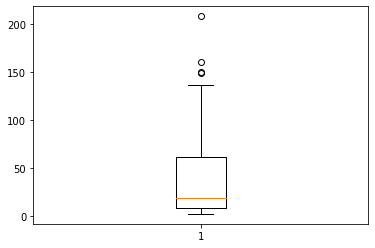

In [6]:
# analyzing ouliers 
plt.boxplot(df02['child_mort'])
plt.show()

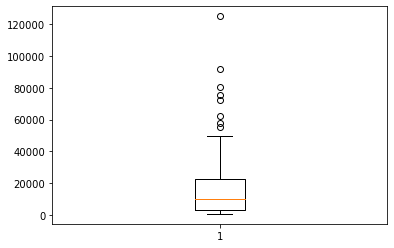

In [7]:
plt.boxplot(df02['income'])
plt.show()

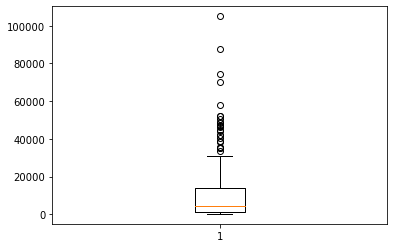

In [8]:
plt.boxplot(df02['gdpp'])
plt.show()

In [9]:
df02.gdpp.quantile([0.05,0.25,0.5,0.75,0.80,0.85,0.9,0.95,0.99,1])

0.05       465.9
0.25      1330.0
0.50      4660.0
0.75     14050.0
0.80     21020.0
0.85     31090.0
0.90     41840.0
0.95     48610.0
0.99     79088.0
1.00    105000.0
Name: gdpp, dtype: float64

In [10]:
# Removing rows for which gdpp is greater than 80 percentile as these are more developed than other countries
df02 = df02[df02.gdpp < df02.gdpp.quantile(.80)]
df02

,country,child_mort,income,gdpp
0,Afghanistan,90.2,1610,553
1,Albania,16.6,9930,4090
2,Algeria,27.3,12900,4460
3,Angola,119.0,5900,3530
4,Antigua and Barbuda,10.3,19100,12200
...,...,...,...,...
162,Vanuatu,29.2,2950,2970
163,Venezuela,17.1,16500,13500
164,Vietnam,23.3,4490,1310
165,Yemen,56.3,4480,1310


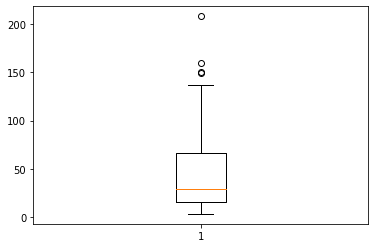

In [11]:
# After removing outliers
plt.boxplot(df02['child_mort'])
plt.show()

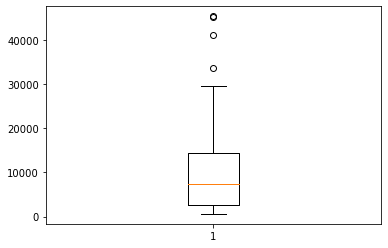

In [12]:
plt.boxplot(df02['income'])
plt.show()

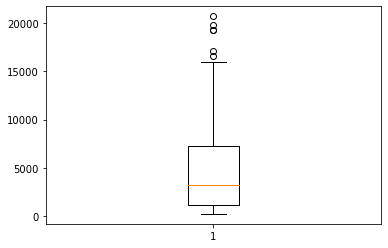

In [13]:
plt.boxplot(df02['gdpp'])
plt.show()

In [14]:
# 2. rescaling
rfm_df = df02[['child_mort', 'income', 'gdpp']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(133, 3)

In [15]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['child_mort', 'income', 'gdpp']
rfm_df_scaled.head()

,child_mort,income,gdpp
0,1.061607,-0.909062,-0.906026
1,-0.736199,0.025356,-0.184565
2,-0.474833,0.358916,-0.109095
3,1.765096,-0.427253,-0.298792
4,-0.890087,1.055237,1.469674


## Hopkins Statistics:

In [16]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [17]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df_scaled)

0.9170433336095228

# 4. Modelling

## K Means Clustering

In [18]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [19]:
kmeans.labels_

array([0, 1, 1, 0, 2, 2, 1, 1, 3, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 2, 0, 0,
       1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 2, 0, 2, 3, 1, 1, 1, 1, 3, 1, 2,
       1, 2, 0, 1, 0, 1, 1, 0, 0, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0, 1,
       0, 2, 2, 0, 0, 2, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 0,
       1, 1, 0, 0, 3, 0, 2, 1, 1, 1, 2, 2, 2, 0, 1, 3, 0, 1, 2, 0, 2, 1,
       1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1,
       0], dtype=int32)

### Finding the Optimal Number of Clusters

#### SSD

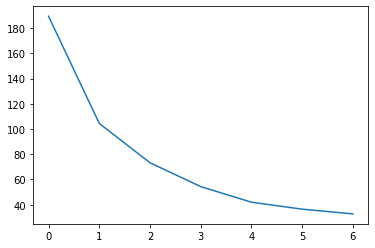

In [20]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)
plt.show()

### Silhouette Analysis

In [21]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.48614291241464186
For n_clusters=3, the silhouette score is 0.48473279413065967
For n_clusters=4, the silhouette score is 0.4797099892355871
For n_clusters=5, the silhouette score is 0.45521914218261766
For n_clusters=6, the silhouette score is 0.4193809842855525
For n_clusters=7, the silhouette score is 0.41837336933863406
For n_clusters=8, the silhouette score is 0.4139339638544138


#### Choosing '4' as the final No. of clusters

In [22]:
# final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [23]:
kmeans.labels_

array([0, 3, 3, 0, 2, 2, 3, 3, 1, 3, 2, 2, 3, 0, 3, 3, 3, 3, 2, 2, 0, 0,
       3, 0, 3, 0, 0, 2, 3, 3, 0, 0, 3, 2, 0, 2, 1, 3, 3, 3, 3, 1, 3, 2,
       3, 2, 0, 3, 0, 3, 3, 0, 0, 3, 0, 2, 3, 3, 2, 3, 3, 3, 2, 0, 0, 3,
       0, 2, 2, 0, 0, 2, 2, 3, 0, 0, 2, 3, 0, 0, 2, 3, 3, 3, 2, 3, 0, 0,
       3, 3, 0, 0, 1, 0, 2, 3, 3, 3, 2, 2, 2, 0, 3, 1, 0, 3, 2, 0, 2, 3,
       3, 3, 3, 0, 2, 3, 0, 3, 3, 0, 3, 3, 2, 3, 0, 3, 2, 3, 3, 2, 3, 3,
       0], dtype=int32)

In [24]:
# assign the label
df02['cluster_id'] = kmeans.labels_
df02.head()

,country,child_mort,income,gdpp,cluster_id
0,Afghanistan,90.2,1610,553,0
1,Albania,16.6,9930,4090,3
2,Algeria,27.3,12900,4460,3
3,Angola,119.0,5900,3530,0
4,Antigua and Barbuda,10.3,19100,12200,2


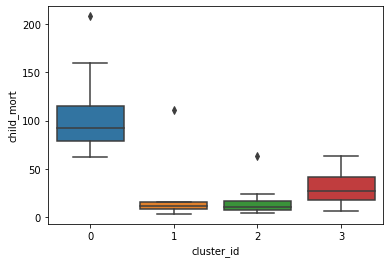

In [25]:
# plot
sns.boxplot(x='cluster_id', y='child_mort', data=df02)
plt.show()

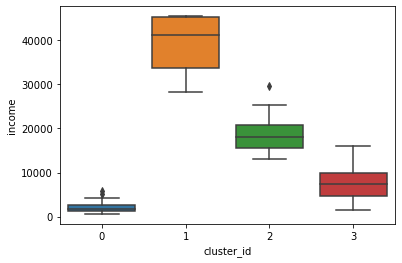

In [26]:
# plot
sns.boxplot(x='cluster_id', y='income', data=df02)
plt.show()

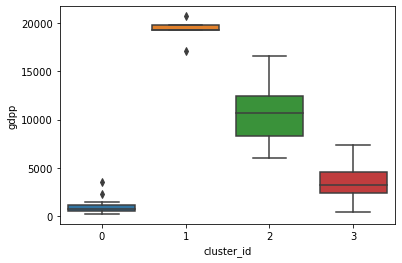

In [27]:
# plot
sns.boxplot(x='cluster_id', y='gdpp', data=df02)
plt.show()

#### We have to select the countries whose child_mort is high, income is low and gdpp is low.
#### From the graphs, we can see that cluster_d = 2 is the most fiiting cluster representing under-developed countries

In [28]:
# filtering countries for which cluster_id = 2
df_cluster_id_2 = df02[df02.cluster_id==2]
df_cluster_id_2.head()

,country,child_mort,income,gdpp,cluster_id
4,Antigua and Barbuda,10.3,19100,12200,2
5,Argentina,14.5,18700,10300,2
13,Barbados,14.2,15300,16000,2
14,Belarus,5.5,16200,6030,2
22,Brazil,19.8,14500,11200,2


In [29]:
# Selecting top 5 countries which has lowest gdpp
df_cluster_id_2 = df_cluster_id_2.sort_values(by=['gdpp'])
df_cluster_id_2.head()

,country,child_mort,income,gdpp,cluster_id
14,Belarus,5.5,16200,6030,2
71,Iran,19.3,17400,6530,2
104,Montenegro,6.8,14000,6680,2
24,Bulgaria,10.8,15300,6840,2
100,Mauritius,15.0,15900,8000,2


## Hierarchical Clustering

In [30]:
rfm_df_scaled.head()

,child_mort,income,gdpp
0,1.061607,-0.909062,-0.906026
1,-0.736199,0.025356,-0.184565
2,-0.474833,0.358916,-0.109095
3,1.765096,-0.427253,-0.298792
4,-0.890087,1.055237,1.469674


In [31]:
df02.head()

,country,child_mort,income,gdpp,cluster_id
0,Afghanistan,90.2,1610,553,0
1,Albania,16.6,9930,4090,3
2,Algeria,27.3,12900,4460,3
3,Angola,119.0,5900,3530,0
4,Antigua and Barbuda,10.3,19100,12200,2


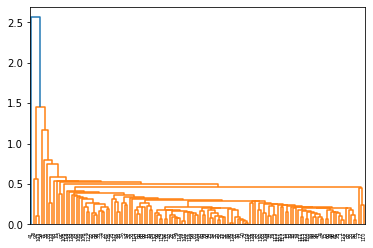

In [32]:
# single linkage
single_linkage = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(single_linkage)
plt.show()

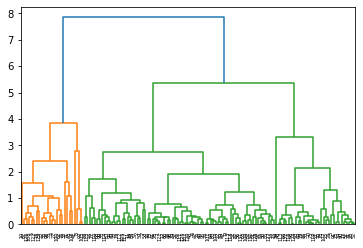

In [33]:
# complete linkage
complete_linkage = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(complete_linkage)
plt.show()

In [34]:
# 3 clusters
cluster_labels = cut_tree(complete_linkage, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 2, 2, 1, 1, 3, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0,
       1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 2, 2, 1, 1, 1, 1, 3, 1, 2,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       0, 2, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 3, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 2, 0, 2, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1,
       0])

In [35]:
# assign cluster labels
df02['cluster_labels'] = cluster_labels
df02.head()

,country,child_mort,income,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,1610,553,0,0
1,Albania,16.6,9930,4090,3,1
2,Algeria,27.3,12900,4460,3,1
3,Angola,119.0,5900,3530,0,0
4,Antigua and Barbuda,10.3,19100,12200,2,2


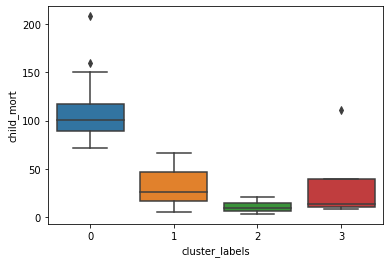

In [36]:
# plots
sns.boxplot(x='cluster_labels', y='child_mort', data=df02)
plt.show()

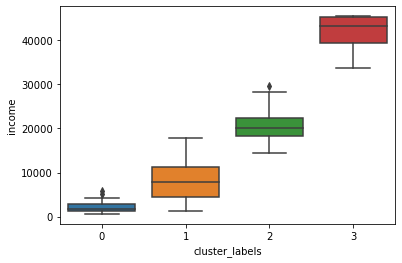

In [37]:
sns.boxplot(x='cluster_labels', y='income', data=df02)
plt.show()

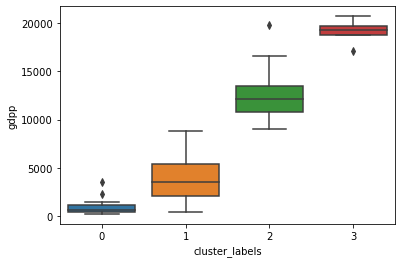

In [38]:
sns.boxplot(x='cluster_labels', y='gdpp', data=df02)
plt.show()

#### We have to select the countries whose child_mort is high, income is low and gdpp is low.
#### From the graphs, we can see that cluster_labels = 0 is the most fiiting cluster representing under-developed countries

In [39]:
# filtering countries for which cluster_labels = 0
df_cluster_label_0 = df02[df02.cluster_labels==0]
df_cluster_label_0.head()

,country,child_mort,income,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,1610,553,0,0
3,Angola,119.0,5900,3530,0,0
17,Benin,111.0,1820,758,0,0
25,Burkina Faso,116.0,1430,575,0,0
26,Burundi,93.6,764,231,0,0


In [40]:
# Selecting top 5 countries which has lowest gdpp
df_cluster_label_0 = df_cluster_label_0.sort_values(by=['gdpp'])
df_cluster_label_0.head()

,country,child_mort,income,gdpp,cluster_id,cluster_labels
26,Burundi,93.6,764,231,0,0
88,Liberia,89.3,700,327,0,0
37,"Congo, Dem. Rep.",116.0,609,334,0,0
112,Niger,123.0,814,348,0,0
132,Sierra Leone,160.0,1220,399,0,0


# Final List of Countries

### 5 Countries which are in direst need of aid:
1. Burundi
2. Liberia
3. Congo, Dem. Rep.
4. Niger
5. Sierra Leone